In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as px

# Data Engineering

In [2]:
AAPL = pd.read_excel("./data/AAPL_EQUITY.xlsx")
AAPL.head()

,Date,Last Px,Volume,SMAVG(15)
0,2024-04-26,169.52,25.946M,56.944M
1,2024-04-25,169.89,50.558M,58.021M
2,2024-04-24,169.02,48.252M,58.231M
3,2024-04-23,166.90,49.538M,58.193M
4,2024-04-22,165.84,48.116M,58.179M


<Axes: xlabel='Date'>

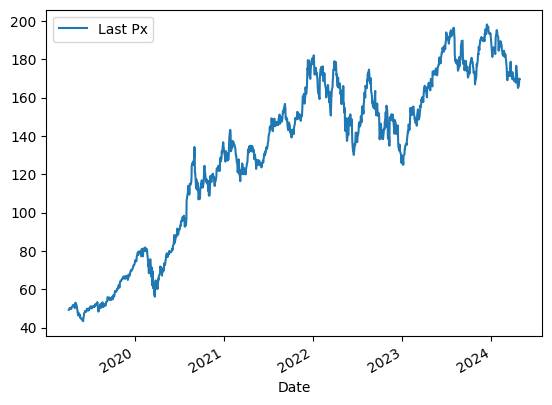

In [3]:
AAPL.plot('Date','Last Px')

In [4]:
SPESG = pd.read_excel(('./data/SPESG_Index_5Y.xlsx')).dropna()
SPESG.head()

,Date,Last Px
0,2024-04-26,453.52
1,2024-04-25,446.47
2,2024-04-24,447.28
3,2024-04-23,446.95
4,2024-04-22,441.80


Text(0.5, 1.0, 'AAPL Equity vs SPESG 5Y')

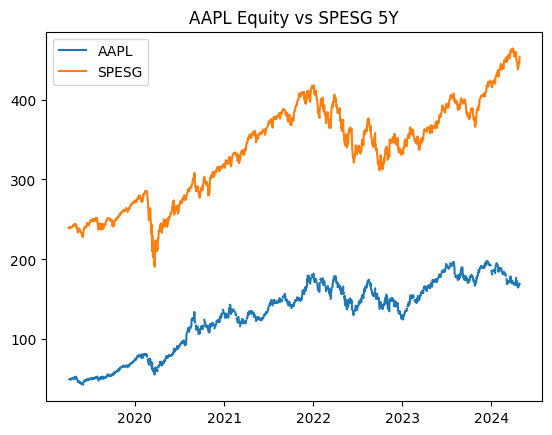

In [5]:
# Conver to Series
x1 = AAPL['Date']
y1 = AAPL['Last Px']

x2 = SPESG['Date']
y2 = SPESG['Last Px']

plt.plot(x1,y1,label="AAPL")
plt.plot(x2,y2,label="SPESG")
plt.legend(loc="upper left")
plt.title("AAPL Equity vs SPESG 5Y")

In [6]:
# Test correlations
from scipy.stats import pearsonr

data1 = AAPL['Last Px'].dropna()
data1.drop(data1.tail(1).index, inplace=True)
data2 = SPESG['Last Px'].dropna().shift(-1).dropna()

corr, _ = pearsonr(data1,data2)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.937


In [70]:
# Take SPESG and AAPL and combine them into one data frame: df['Date', 'SPESG', 'AAPL_Px', 'AAPL_Volume', 'AAPL_SMAVG(15)']
df = pd.merge(AAPL, SPESG, on='Date', how='inner')
new_columns = {'Last Px_x' : 'AAPL_Px', 'Volume': 'AAPL_Volume(M)', 'SMAVG(15)' : 'AAPL_SMAVG15(M)', 'Last Px_y': 'SPESG'}
df.rename(columns=new_columns, inplace=True)

# Strip M and convert these columns from object into float64
df['AAPL_Volume(M)'] = df['AAPL_Volume(M)'].str.strip('M').astype('float64')
df['AAPL_SMAVG15(M)'] = df['AAPL_SMAVG15(M)'].str.strip('M').astype('float64')
df['Date'] = pd.to_datetime(df['Date'])
df['AAPL_Px_Shift1'] = df['AAPL_Px'].shift(-1)
df = df.sort_values(by='Date', ascending=True).dropna()

# Feature Engineering
What will be other features that might help our model to predict the target variable better? <br>
Year, Month, day, Lagged price, lagged volume, daily volatility, Quarter, rolling averages, momentum(rate of change), change in volume, return, Price*Volume, Price to Moving Average Ratio, Volume Weighted Average Price (VWAP), SMAVG30(M), SMAVG60(M), SMAVG120(M), SMAVG500(M), etc.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1260 entries, 1259 to 0
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1260 non-null   datetime64[ns]
 1   AAPL_Px          1260 non-null   float64       
 2   AAPL_Volume(M)   1260 non-null   float64       
 3   AAPL_SMAVG15(M)  1260 non-null   float64       
 4   SPESG            1260 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 59.1 KB


In [88]:
from sklearn.model_selection import train_test_split
# features = ['AAPL_Volume(M)', 'AAPL_SMAVG15(M)', 'SPESG', 'Month', 'Year', 'Day']
features = ['AAPL_Volume(M)', 'AAPL_SMAVG15(M)', 'SPESG', 'AAPL_Px_Shift1']
target = ['AAPL_Px']
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


# Modeling 
Use 3 years of S&P 500 ESG data and 3 years of Apple's stock price data to predict Apple's stock price. Since we are using different features to predict the target variable, we can use a regression model. 
- We can use a simple linear regression model to predict the stock price, or we can use Naive Bayes model, or we can also use a more complex model like Random Forest, Gradient Boosting, etc. to predict the stock price. 
- We can also use a time series model like ARIMA, LSTM, etc. to predict the stock price. 
- We can also use a hybrid model that combines the regression model and the time series model to predict the stock price. <br><br>

**Base Rate** model: Here, we will first use a simple linear regression model to predict the stock price as the base rate.
## Linear Regression Model

In [78]:
print(len(X_train), len(y_train))

630 630


In [85]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

Coefficients:  [[-0.00211847  0.00110984  0.01333341  0.98013466]]
Variance score: 0.9970315820445652
5.535467473801275
0.9970315820445652


Performance and overfitting measures:

In [87]:
# Training set
y_pred_train = regressor.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)

# Test set
y_pred_test = regressor.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"r2_train: {r2_train}")
print(f"r2_test: {r2_test}")

def adjusted_r2_score(r_squared, n, k):
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))

n_samples = X_train.shape[0]
n_features = X_train.shape[1]

adj_r2_train = adjusted_r2_score(r2_train, n_samples, n_features)
adj_r2 = adjusted_r2_score(r2_test, n_samples, n_features)
print("Adjusted R-squared on Training Data:", adj_r2_train)
print("Adjusted R-squared on Test Data:", adj_r2)

r2_train: 0.9967341742246516
r2_test: 0.9970315820445652
Adjusted R-squared on Training Data: 0.9967132729396894
Adjusted R-squared on Test Data: 0.9970125841696504


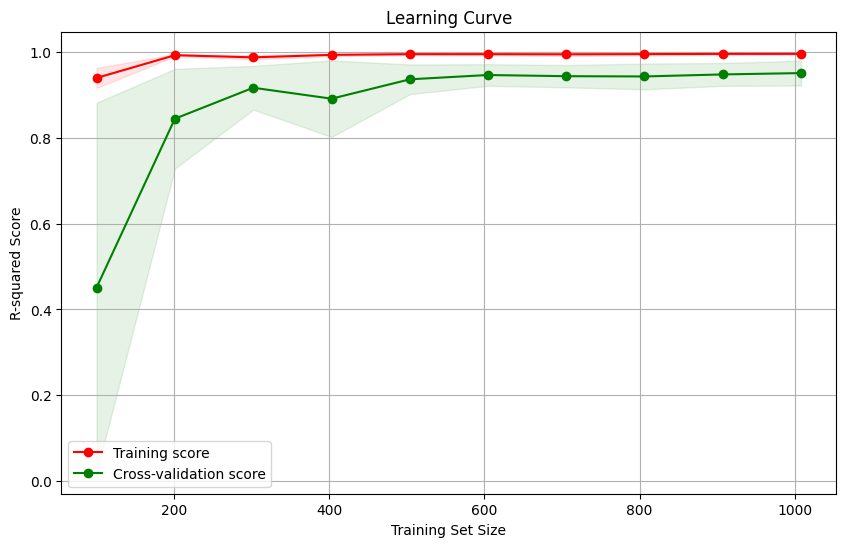

In [89]:
from sklearn.model_selection import learning_curve
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(
    regressor, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

# Create plot labels and title
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R-squared Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

**Possibility of High Variance:** The gap between training and validation scores, combined with high absolute scores, may indicate the model has high variance. Considering some regularization or model complexity reduction might help if the gap is considered too large.